In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
from q_value_calc_crosslinks import calcQ
import matplotlib.pyplot as plt
from functions import get_target_id, get_datasets, rerank, get_top_indices
import re
import os

In [2]:
i = 1
n_iters = 5
pep_filter = False
class_threshold = 500
dataset = get_datasets()

In [3]:
input_filename = f"{dataset[i]['file']}.pkl"
input_file = f"../data/{dataset[i]['type']}/{dataset[i]['name']}/{input_filename}" 


In [4]:
# read original dataframes
original_df = pd.read_pickle(input_file)

In [5]:
if dataset[i]['type'] == 'crosslink_data':

    features = ['Score','peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                    'NuXL:mass_error_p', 'NuXL:tag_XLed', 'NuXL:tag_unshifted' ,
                    'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                    'variable_modifications']
elif dataset[i]['type'] == 'top_down_data':
    features = ['Score', 'NumMass', 'MatchingFragments', 'Coverage(%)', 'TagCount', 'ModCount', 'PrecursorQscore']

# filter data and sort according to descending score
original_df = original_df.filter(np.concatenate([features,['ScanNr', 'rank', 'Label', 'PSMId', 'Peptide']]))
original_df.sort_values('Score',ascending=False, inplace=True)


In [ ]:
 # initialise the k-fold cross validator
no_split = 5
kf = KFold(n_splits=no_split, shuffle=True, random_state=1)

param_grid = {
        'svc__C': np.power(float(2), [-5,-1,1,5,7,11,15]),
        #'svc__class_weight': [{1:0.3,0:0.7},{1:0.4,0:0.6},{1:0.5,0:0.5}]
    }

pipe = make_pipeline(MinMaxScaler(), SVC(kernel='linear'))
# create the pipeline
gs = GridSearchCV(pipe,
                param_grid=param_grid, 
                n_jobs=-1,
                scoring="accuracy",
                cv=kf, 
                refit=True,
                verbose = 2)
# filter dataframes
filter_col = 'PSMId'
filter_val = 1

train_idx_list_bottom = []
train_idx_list_top = []
class_weights = []
for iteration in range(1,n_iters + 1):
    
   # sort dataframe according to Score column
    original_df.sort_values('Score',ascending=False, inplace=True)
    if dataset[i]['type'] == 'crosslink_data':
        if pep_filter:
            peptides_top_indices = pd.Index(get_top_indices(original_df, "Peptide", "Score"))
            psm_top_indices = pd.Index(get_top_indices(original_df, "ScanNr", "Score"))
            top_indices = peptides_top_indices.intersection(psm_top_indices)
        else:
            top_indices = pd.Index(get_top_indices(original_df, "ScanNr", "Score"))
    elif dataset[i]['type'] == 'top_down_data':
        top_indices = pd.Index(get_top_indices(original_df, "ScanNr", "Score"))
    # determine minority class 
    classes = []
    for c in np.unique(original_df[dataset[i]['group']]):
        group_indices = original_df.loc[(original_df[dataset[i]['group']] == c),:].index
        filtered_indices = top_indices.intersection(group_indices)
        classes.append(len(original_df.loc[filtered_indices,:]))
    minority_class = min(classes)
    
    if (minority_class > class_threshold):
        print("Truncating to " + str(class_threshold) + "\n") 
        minority_class = class_threshold

    # define training data (top and bottom scores of each class with PSMId = 1)
    train_idx = []
    train_idx_list_bottom_iter = []
    train_idx_list_top_iter = []
    original_df['train_label'] = np.NaN
    original_df.sort_values('Score',ascending=False, inplace=True)
    for c in np.unique(original_df[dataset[i]['group']]):
        group_indices = original_df.loc[(original_df[dataset[i]['group']] == c),:].index
        filtered_indices = top_indices.intersection(group_indices)
        class_top = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[:int(minority_class/2)]
        class_bottom = original_df.loc[filtered_indices,:].sort_values('Score',ascending=False)[-int(minority_class/2):]
        original_df.loc[class_top.index,'train_label'] = 1
        original_df.loc[class_bottom.index,'train_label'] = 0
        
        train_idx = np.concatenate([train_idx, class_top.index, class_bottom.index])
        train_idx_list_bottom_iter = np.concatenate([train_idx_list_bottom_iter, class_bottom.index])
        train_idx_list_top_iter = np.concatenate([train_idx_list_top_iter, class_top.index])
    train_idx_list_bottom.append(train_idx_list_bottom_iter) 
    train_idx_list_top.append(train_idx_list_top_iter)
    # fit SVM
    gs.fit(original_df.loc[train_idx, features], original_df.loc[train_idx, 'train_label'])
    class_weights.append(gs.best_params_)

    # save previous score
    original_df[f'Score_{iteration - 1}'] = original_df['Score']
    # overwrite new score
    original_df['Score'] = gs.decision_function(original_df.loc[:,features])

    
    original_df[f"PSMId_{iteration - 1}"] = original_df['PSMId']
    if dataset[i]['type'] != 'top_down_data':
        original_df = rerank(original_df, "ScanNr", "Score", "PSMId")

    # save entire dataframe
    directory=f"../data/{dataset[i]['type']}/{dataset[i]['name']}/{class_threshold}/"
    if pep_filter:
        directory += "pep_unique/"
    else:
        directory += "default/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    output_file = re.sub('.pkl', f"_SVM_iter_{iteration}.pkl", input_filename)
    path = directory + output_file
    original_df.to_pickle(path)

    original_df_filtered_new = original_df
    # filter for rank = 0
    original_df_filtered_new = original_df.loc[original_df[filter_col] == filter_val,:]
    
    # compute q-values
    q_vals_SVM = calcQ(original_df_filtered_new, classColName=dataset[i]['group'])
    # compute target IDs
    target_ID = get_target_id(q_vals_SVM, isXLColName=dataset[i]['group'])
    # save file with q-values
    if pep_filter:
        filename = f"_SVM_iter_{iteration}_pep.pkl"
    else:
        filename = f"_SVM_iter_{iteration}.pkl"
    output_file = re.sub('.pkl', filename, input_filename)
    if not os.path.exists(directory + "filtered/"):
        os.makedirs(directory + "filtered/")
    path = directory + "filtered/" + output_file
    #output_file = re.sub('.pkl', f"_SVM_filtered_no_rerank_iter_{iteration}.pkl", input_file)
    target_ID.to_pickle(path) # save filtered dataframe

Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace

Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace

Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace

Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace

Truncating to 500

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(scoreColName, ascending=ascending, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace

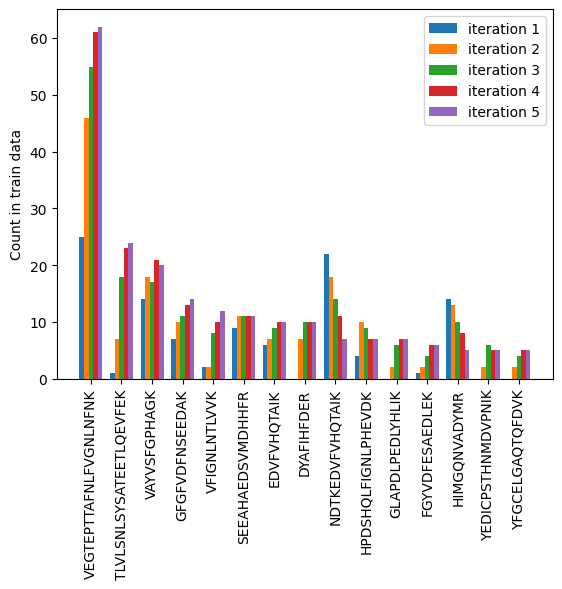

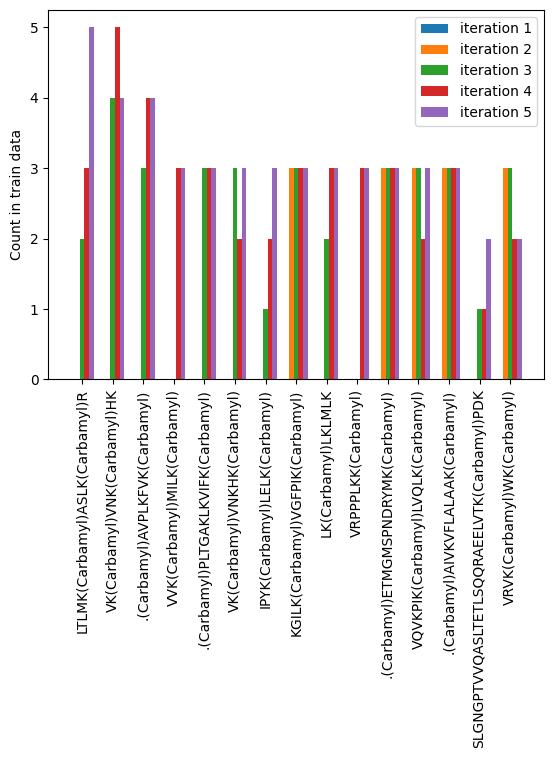

In [7]:
count_df_top = pd.DataFrame(np.zeros((len(np.unique(original_df['Peptide'])),len(train_idx_list_top))), index=np.unique(original_df['Peptide']), columns=range(0,len(train_idx_list_top)))
mean_label = original_df.groupby("Peptide")['Label'].apply(np.mean)
count_df_top.loc[mean_label.index,"mean_label"] = mean_label.values
for i,train_idx in enumerate(train_idx_list_top):
    counts = original_df.loc[train_idx_list_top[i],'Peptide'].value_counts()
    count_df_top.loc[counts.keys(),i] = counts.values
count_df_top.sort_values(4, ascending=False, inplace=True)
head = 15
x = np.arange(head)
width = 0.15
for i,col in enumerate(count_df_top.columns):
    if type(col) == int:
        plt.bar(x + i*width,count_df_top.head(head)[col],width=width, label=f'iteration {i + 1}')
plt.xticks(x + 2*width, count_df_top.head(head).index, rotation=90)
plt.legend()
plt.ylabel('Count in train data')
plt.show()
count_df_bottom = pd.DataFrame(np.zeros((len(np.unique(original_df['Peptide'])),len(train_idx_list_bottom))), index=np.unique(original_df['Peptide']), columns=range(0,len(train_idx_list_bottom)))
mean_label = original_df.groupby("Peptide")['Label'].apply(np.mean)
count_df_bottom.loc[mean_label.index,"mean_label"] = mean_label.values
for i,train_idx in enumerate(train_idx_list_bottom):
    counts = original_df.loc[train_idx_list_bottom[i],'Peptide'].value_counts()
    count_df_bottom.loc[counts.keys(),i] = counts.values
count_df_bottom.sort_values(4, ascending=False, inplace=True)
head = 15
x = np.arange(head)
width = 0.15
for i,col in enumerate(count_df_bottom.columns):
    if type(col) == int:
        plt.bar(x + i*width,count_df_bottom.head(head)[col],width=width, label=f'iteration {i + 1}')
plt.xticks(x + 2*width, count_df_bottom.head(head).index, rotation=90)
plt.legend()
plt.ylabel('Count in train data')
plt.show()

In [8]:
for col in count_df_top.columns:
    if type(col) == int:
        count_df_top.sort_values(col, ascending=False, inplace=True)
        count_df_top[f"arg {col}"] = range(len(count_df_top))
display(count_df_top)
for col in count_df_bottom.columns:
    if type(col) == int:
        count_df_bottom.sort_values(col, ascending=False, inplace=True)
        count_df_bottom[f"arg {col}"] = range(len(count_df_bottom))
display(count_df_bottom)

,0,1,2,3,4,mean_label,arg 0,arg 1,arg 2,arg 3,arg 4
VEGTEPTTAFNLFVGNLNFNK,25.0,46.0,55.0,61.0,62.0,1.0,0,0,0,0,0
TLVLSNLSYSATEETLQEVFEK,1.0,7.0,18.0,23.0,24.0,1.0,158,11,1,1,1
VAYVSFGPHAGK,14.0,18.0,17.0,21.0,20.0,1.0,3,1,2,2,2
GFGFVDFNSEEDAK,7.0,10.0,11.0,13.0,14.0,1.0,10,8,6,3,3
VFIGNLNTLVVK,2.0,2.0,8.0,10.0,12.0,1.0,90,45,13,7,4
...,...,...,...,...,...,...,...,...,...,...,...
YTLSKENPK(Carbamyl),0.0,0.0,0.0,0.0,0.0,0.0,96835,32436,96887,32427,96898
YSQEPIK(Carbamyl)TFSRFK(Carbamyl),0.0,0.0,0.0,0.0,0.0,1.0,96834,32435,96888,32426,96899
YSPPITCFGMDK,0.0,0.0,0.0,0.0,0.0,0.0,96833,32434,96889,32425,96900
YSITKNDYM(Oxidation)M(Oxidation)MVDEK,0.0,0.0,0.0,0.0,0.0,0.0,96832,32433,96890,32424,96901


,0,1,2,3,4,mean_label,arg 0,arg 1,arg 2,arg 3,arg 4
LTLMK(Carbamyl)ASLK(Carbamyl)R,0.0,0.0,2.0,3.0,5.0,0.0,1759,66231,23,2,0
VK(Carbamyl)VNK(Carbamyl)HK,0.0,0.0,4.0,5.0,4.0,0.0,80709,48418,1,0,1
.(Carbamyl)AVPLKFVK(Carbamyl),0.0,0.0,3.0,4.0,4.0,1.0,64686,672,2,1,2
.(Carbamyl)PLTGAKLKVIFK(Carbamyl),0.0,0.0,3.0,3.0,3.0,0.0,64684,671,8,7,3
VK(Carbamyl)VNKHK(Carbamyl),0.0,0.0,3.0,2.0,3.0,0.0,64683,656,9,24,4
...,...,...,...,...,...,...,...,...,...,...,...
YSLDVVNGLLFLHSQSIVHLDLK(Carbamyl),0.0,0.0,0.0,0.0,0.0,1.0,96559,32595,96817,32586,96898
YSLELGK(Carbamyl),0.0,0.0,0.0,0.0,0.0,1.0,96560,32594,96818,32585,96899
YSLK(Carbamyl)VNVLK,0.0,0.0,0.0,0.0,0.0,0.0,96561,32593,96819,32584,96900
YSLRIWLK,0.0,0.0,0.0,0.0,0.0,0.0,96562,32592,96820,32583,96901


In [9]:
print(len(count_df_top.loc[(count_df_top['mean_label'] == 0),:]))  
print(len(count_df_top.loc[(count_df_top['mean_label'] == 1),:]))  
for i in range(5):
    print(len(count_df_top.loc[(count_df_top[i] > 0) & (count_df_top['mean_label'] == 0),:]))
  
for i in range(5):
    print(len(count_df_bottom.loc[(count_df_bottom[i] > 0) & (count_df_bottom['mean_label'] == 1),:]))

50080
46823
0
0
0
0
0
219
222
204
203
200


In [10]:
#from sklearn.manifold import TSNE
#import seaborn as sns

#tsne = TSNE(n_components=2, random_state=0)
#projections = tsne.fit_transform(original_df.loc[:,features])


[Text(0.5, 1.0, 'PCA projection')]

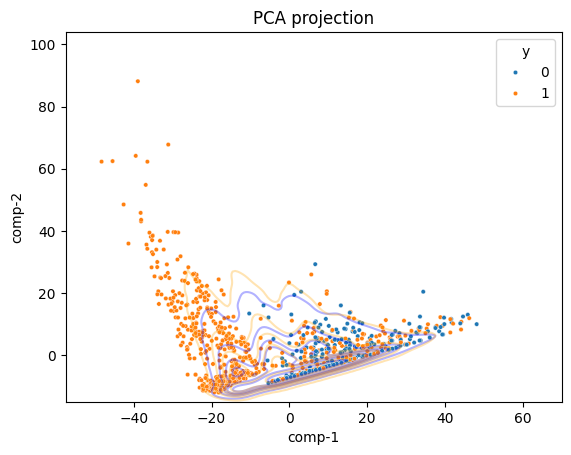

In [11]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(original_df.loc[:,features])

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['comp-1', 'comp-2'], index = original_df.index)
principalDf["y"] = original_df.loc[:,'Label']
principalDf['train'] = 0
principalDf.loc[train_idx_list_top[4],'train'] = 1
principalDf.loc[train_idx_list_bottom[4],'train'] = 1
sns.kdeplot(
    data=principalDf.loc[principalDf['y'] == 0,:],
    x="comp-1", y="comp-2",
    levels=7,
    fill=False,
    alpha=0.3,
    cut=2,
    color='blue'
)
sns.kdeplot(
    data=principalDf.loc[principalDf['y'] == 1,:],
    x="comp-1", y="comp-2",
    levels=7,
    fill=False,
    alpha=0.3,
    cut=2,
    color='orange'
)
#sns.scatterplot(x="comp-1", y="comp-2", hue='y', alpha=0.1,
#                palette=sns.color_palette("hls", 3),s=10,
#                data=principalDf.loc[principalDf['train'] == 0,:]).set(title="PCA projection") 
sns.scatterplot(x="comp-1", y="comp-2", hue='y',
                s=10,
                data=principalDf.loc[principalDf['train'] == 1,:]).set(title="PCA projection") 

In [12]:
df = pd.DataFrame(projections, index=original_df.index)
df["y"] = original_df_filtered_new.loc[:,'Label']
df.index = original_df_filtered_new.index
df['train'] = 0
df.loc[train_idx,'train'] = 1
df["comp-1"] = projections[:,0]
df["comp-2"] = projections[:,1]
print(df)
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Iris data T-SNE projection") 

NameError: name 'projections' is not defined

In [ ]:
print(projections)
df = pd.DataFrame()
df["y"] = original_df_filtered_new.loc[:,'Label']
df.index = original_df_filtered_new.index
df['train'] = 0
df.loc[train_idx,'train'] = 1
df["comp-1"] = projections[:,0]
df["comp-2"] = projections[:,1]
print(df)
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Iris data T-SNE projection") 

[[ 108.638794    -9.041021 ]
 [ 108.4436      -8.2758045]
 [ 106.575134   -12.540949 ]
 ...
 [ -25.813465  -105.87721  ]
 [ -19.454098  -110.28918  ]
 [ -19.634775  -111.01197  ]]
1000


KeyError: '[84063.0, 77329.0, 71020.0, 136389.0, 125537.0, 136460.0, 138150.0, 39599.0, 138888.0, 128038.0, 121704.0, 138023.0, 130177.0, 136007.0, 99817.0, 74766.0, 143407.0, 7817.0, 139950.0, 131162.0, 94404.0, 13406.0, 90648.0, 93576.0, 144081.0, 127271.0, 114841.0, 137053.0, 86305.0, 125479.0, 133959.0, 112448.0, 117943.0, 135451.0, 116824.0, 139409.0, 125191.0, 2952.0, 143267.0, 129308.0, 14358.0, 62712.0, 5437.0, 136194.0, 55024.0, 90808.0, 115079.0, 143695.0, 89104.0, 67729.0, 130893.0, 135385.0, 5813.0, 489.0, 89241.0, 82294.0, 115712.0, 75287.0, 132954.0, 124478.0, 131989.0, 44590.0, 125858.0, 112728.0, 113623.0, 136118.0, 13973.0, 28800.0, 7454.0, 930.0, 76275.0] not in index'

In [ ]:
score_cols = ['Score_1', 'Score_2', 'Score_3', 'Score_4', 'Score']

for score_col in score_cols:
    original_df.sort_values(score_col, ascending=False, inplace=True)
    original_df[f"arg {score_col}"] = range(len(original_df))
display(original_df)

,Score,peplen,NuXL:isXL,NuXL:modds,NuXL:pl_modds,NuXL:mass_error_p,NuXL:tag_XLed,NuXL:tag_unshifted,NuXL:tag_shifted,missed_cleavages,...,PSMId_2,Score_3,PSMId_3,Score_4,PSMId_4,arg Score_1,arg Score_2,arg Score_3,arg Score_4,arg Score
12092,1.200924,16,1,96.218964,36.101994,0.995388,15,13,14,0,...,1,1.279507,1,1.226792,1,4,1,0,0,0
20899,1.178728,16,1,89.818802,44.670109,0.938060,15,15,5,0,...,1,1.254467,1,1.203281,1,3,2,2,1,1
103646,1.164054,18,1,77.301033,17.423250,0.999942,16,16,3,0,...,1,1.213909,1,1.181252,1,36,4,3,3,2
23703,1.160198,40,0,165.613602,0.000000,0.956545,0,25,0,0,...,1,1.272535,1,1.194727,1,0,0,1,2,3
88602,1.156555,14,1,70.784744,35.132381,0.999980,12,13,4,0,...,1,1.202822,1,1.172503,1,29,5,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21367,-1.784039,76,1,3.307934,2.026585,0.127109,0,1,1,2,...,2,-1.774391,2,-1.775490,2,144343,144391,144390,144390,144390
98071,-1.786959,93,0,2.930540,0.000000,0.203272,0,1,0,2,...,8,-1.769464,8,-1.784396,8,144139,144379,144389,144392,144391
21369,-1.788586,77,1,3.307934,1.528515,0.127110,0,1,1,2,...,3,-1.778758,3,-1.780123,3,144353,144392,144392,144391,144392
21370,-1.796295,76,1,2.244814,2.508085,0.127109,0,1,1,2,...,4,-1.789720,4,-1.788789,4,144392,144394,144394,144393,144393


In [ ]:
ax = original_df.loc[train_idx_list_top,['arg Score_1', 'arg Score_2', 'arg Score_3', 'arg Score_4', 'arg Score']].T.plot()
ax.legend([],[], frameon=False)
ax.set_ylim(0,np.max(original_df.loc[train_idx_list_top,['arg Score_1']]))

KeyError: "None of [Index([         (23703.0, 23545.0, 123298.0, 124036.0, 123737.0, 110514.0, 123892.0, 123571.0, 110748.0, 111136.0, 21246.0, 57327.0, 123455.0, 57052.0, 111284.0, 10646.0, 42743.0, 110971.0, 10816.0, 116931.0, 13445.0, 141192.0, 136828.0, 136954.0, 124033.0, 123269.0, 113077.0, 129357.0, 21468.0, 124193.0, 124190.0, 10620.0, 121155.0, 121330.0, 44105.0, 42676.0, 113253.0, 10943.0, 121032.0, 4399.0, 123886.0, 134799.0, 129153.0, 69395.0, 87111.0, 116757.0, 30462.0, 18555.0, 123734.0, 123568.0, 69416.0, 10788.0, 111804.0, 47328.0, 47104.0, 129523.0, 134932.0, 57576.0, 117232.0, 110967.0, 11159.0, 134829.0, 36800.0, 37015.0, 55965.0, 120862.0, 82778.0, 113522.0, 116402.0, 34030.0, 121225.0, 120639.0, 123417.0, 137106.0, 121501.0, 92977.0, 112907.0, 116692.0, 117076.0, 41754.0, 92252.0, 49925.0, 134363.0, 42485.0, 33262.0, 65153.0, 112214.0, 78636.0, 116598.0, 78309.0, 78545.0, 20538.0, 113722.0, 69610.0, 142140.0, 33462.0, 101044.0, 115979.0, 13816.0, 71140.0, ...),\n       (23703.0, 23545.0, 123298.0, 123737.0, 123571.0, 123892.0, 21246.0, 111136.0, 110748.0, 110514.0, 13445.0, 124036.0, 44105.0, 42743.0, 87111.0, 111284.0, 116692.0, 124190.0, 124033.0, 78309.0, 10646.0, 69416.0, 113077.0, 136954.0, 136828.0, 121330.0, 121225.0, 57327.0, 141192.0, 30462.0, 121155.0, 129357.0, 142140.0, 123455.0, 123269.0, 21468.0, 10816.0, 92252.0, 113253.0, 110971.0, 116525.0, 78545.0, 129153.0, 107333.0, 49925.0, 106755.0, 121501.0, 123568.0, 87371.0, 123886.0, 57898.0, 104063.0, 83773.0, 104304.0, 55965.0, 123734.0, 115160.0, 113526.0, 71140.0, 69610.0, 54134.0, 129523.0, 78780.0, 11159.0, 69395.0, 133501.0, 57052.0, 112907.0, 114101.0, 134799.0, 110453.0, 124193.0, 134363.0, 107590.0, 101649.0, 82778.0, 102070.0, 101044.0, 91417.0, 76885.0, 134932.0, 123417.0, 126808.0, 139150.0, 116931.0, 137106.0, 85621.0, 101308.0, 127272.0, 89301.0, 99174.0, 105747.0, 102222.0, 76633.0, 47104.0, 47328.0, 114272.0, 113888.0, 108801.0, 121032.0, ...),\n                   (23703.0, 13445.0, 23545.0, 78309.0, 116692.0, 123737.0, 121225.0, 123571.0, 87111.0, 111136.0, 123298.0, 69416.0, 110748.0, 123892.0, 116525.0, 107333.0, 113077.0, 142140.0, 78545.0, 30462.0, 136954.0, 106755.0, 92252.0, 57898.0, 44105.0, 113526.0, 110514.0, 54134.0, 49925.0, 121330.0, 115160.0, 110453.0, 141192.0, 78780.0, 101649.0, 71140.0, 136828.0, 91417.0, 126808.0, 87371.0, 121155.0, 113253.0, 107590.0, 127272.0, 21246.0, 129357.0, 76633.0, 69610.0, 139150.0, 74300.0, 129153.0, 31260.0, 133501.0, 112507.0, 54067.0, 64541.0, 139883.0, 64895.0, 122115.0, 89552.0, 85621.0, 102281.0, 48380.0, 101308.0, 121945.0, 102070.0, 139219.0, 121501.0, 55965.0, 99174.0, 76885.0, 67296.0, 108801.0, 89313.0, 69698.0, 102222.0, 111284.0, 123541.0, 42315.0, 128552.0, 102893.0, 41046.0, 54777.0, 53909.0, 134363.0, 69666.0, 89281.0, 123699.0, 89564.0, 71310.0, 109044.0, 137106.0, 67698.0, 76883.0, 43926.0, 66804.0, 43679.0, 105747.0, 32448.0, 43394.0, ...),\n                              (23703.0, 13445.0, 78309.0, 116692.0, 121225.0, 107333.0, 116525.0, 69416.0, 113077.0, 78545.0, 106755.0, 87111.0, 57898.0, 54134.0, 113526.0, 30462.0, 142140.0, 110453.0, 92252.0, 115160.0, 136954.0, 101649.0, 91417.0, 71140.0, 126808.0, 49925.0, 78780.0, 76633.0, 127272.0, 107590.0, 112507.0, 89552.0, 74300.0, 31260.0, 54067.0, 64895.0, 141192.0, 102281.0, 121330.0, 139150.0, 122115.0, 69698.0, 42315.0, 67296.0, 69610.0, 64541.0, 87371.0, 48380.0, 102893.0, 121945.0, 139883.0, 89281.0, 53909.0, 89564.0, 43926.0, 89313.0, 43679.0, 54777.0, 113253.0, 67698.0, 66804.0, 41046.0, 133501.0, 38517.0, 57970.0, 101308.0, 99174.0, 108801.0, 72721.0, 109665.0, 43394.0, 45199.0, 9194.0, 136828.0, 76883.0, 92628.0, 85621.0, 139219.0, 121155.0, 33924.0, 92877.0, 102222.0, 69666.0, 110401.0, 106134.0, 102429.0, 83715.0, 65386.0, 98214.0, 129357.0, 85954.0, 110265.0, 67891.0, 109044.0, 81346.0, 60926.0, 127426.0, 37310.0, 65661.0, 105884.0, ...),\n                                    (23703.0, 13445.0, 78309.0, 116692.0, 107333.0, 121225.0, 116525.0, 113077.0, 106755.0, 78545.0, 69416.0, 54134.0, 113526.0, 110453.0, 57898.0, 87111.0, 101649.0, 30462.0, 115160.0, 91417.0, 126808.0, 142140.0, 71140.0, 92252.0, 78780.0, 76633.0, 136954.0, 49925.0, 127272.0, 112507.0, 89552.0, 102281.0, 64895.0, 54067.0, 74300.0, 31260.0, 107590.0, 42315.0, 69698.0, 67296.0, 122115.0, 102893.0, 89281.0, 89564.0, 43926.0, 139150.0, 43679.0, 53909.0, 64541.0, 48380.0, 121945.0, 66804.0, 67698.0, 89313.0, 54777.0, 141192.0, 38517.0, 57970.0, 72721.0, 69610.0, 139883.0, 92628.0, 109665.0, 92877.0, 41046.0, 45199.0, 43394.0, 106134.0, 9194.0, 121330.0, 110401.0, 65386.0, 105884.0, 98214.0, 93584.0, 33924.0, 65661.0, 67891.0, 85954.0, 87371.0, 76883.0, 60926.0, 37310.0, 93306.0, 100470.0, 82352.0, 102429.0, 108801.0, 99174.0, 83715.0, 100732.0, 101308.0, 127426.0, 110265.0, 17671.0, 37565.0, 81346.0, 69666.0, 82867.0, 98461.0, ...)],\n      dtype='object')] are in the [index]"

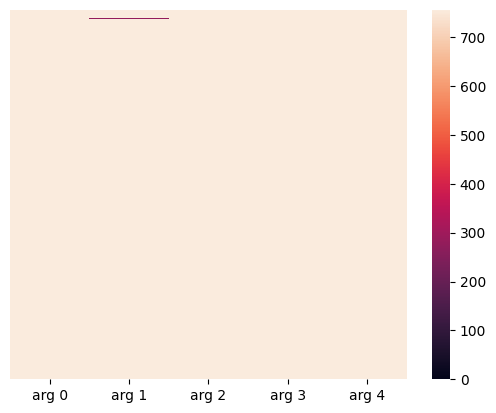

In [ ]:
count_df_bottom.sort_values(['mean_label', 'arg 0' ], ascending=[False, False], inplace=True)
idx_decoys = np.argmin(count_df_bottom['mean_label'])
import seaborn as sns
ax = sns.heatmap(count_df_bottom.loc[count_df_top[0] > 0,['arg 0', 'arg 1', 'arg 2', 'arg 3', 'arg 4']], 
                 vmin=np.min(count_df_bottom.loc[count_df_bottom[0] > 0,['arg 0']]), 
                 vmax=np.max(count_df_bottom.loc[count_df_bottom[0] > 0,['arg 0']]), )
ax.hlines([idx_decoys],*ax.get_xlim(), colors="yellow")
ax.set_yticks([])
plt.show()